Ok I've gotten that first overly simple part down alright. Now let's add in a mass function and see how it plays with the data. 

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [33]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
#dataDir = '/nfs/slac/g/ki/ki19/des/erykoff/clusters/mocks/Buzzard/buzzard-1.1/des_y5/redmapper_v6.4.7/halos/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

import numpy as np
mass = data['M200']
print 'Rows:\t%d'%mass.shape[0]
rich = data['LAMBDA_CHISQ']
redshifts = data['Z']
mass = mass[rich>0]
redshifts = redshifts[rich>0]
rich = rich[rich>0]#slice off null values
logMass = np.log10(mass)
logRich = np.log10(rich)

from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

Rows:	76997
a: 8.261e-05	b: 3.656e-01
R^2: 0.222


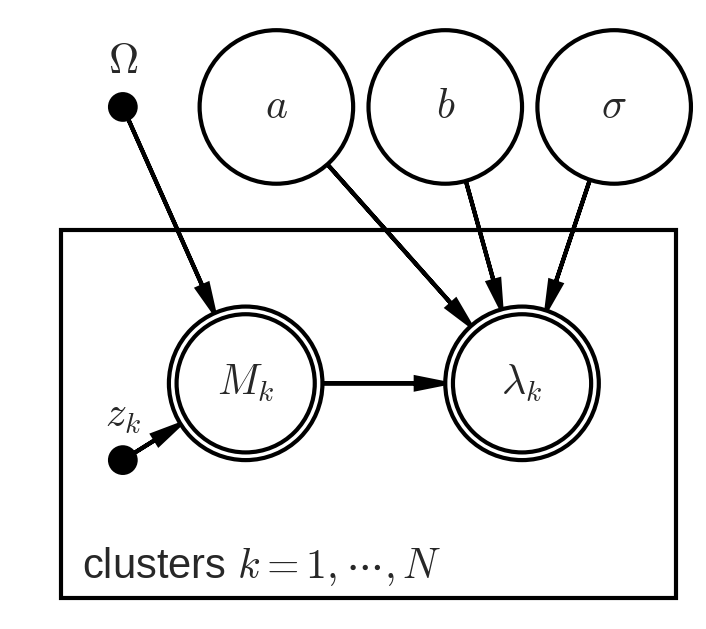

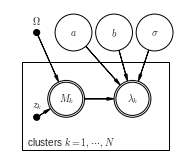

In [34]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,.85,fixed =True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1, observed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_edge("redshift", "Mcluster")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM4.png", dpi = 300)
from IPython.display import Image
Image("modelPGM4.png")

This has the distribution:

$P(a,b,\sigma | \{M\}, \{\lambda\},\{z\}, \Omega ) = \prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma)\;P(M_k | \Omega, z_k)\; P(a,b,\sigma)\;} $

In [35]:
#gonna have to hardcode the mass sampler. 
#First, will need the parameters
vals = {}
z = [0.23, 1.5]
vals['Mp'] = [2.0, 1.0]#*10^14
vals['A'] = [1.944, 0.293]
vals['B1'] = [1.97, 3.07]
vals['B2'] = [0.7, 1.2]
vals['B3'] = [0.40, 0.73]

z_params = {}
from scipy.stats import linregress
for key, val in vals.iteritems():
    slope, intercept, r, p, stderr = linregress(z, val)
    z_params[key] = (slope, intercept)
    
def getMassParams(z):
    return {key:val[0]*z+val[1] for key,val in z_params.iteritems()}

#TODO Log version
def n_approx(m,z):
    params = getMassParams(z)
    return params['A']*np.exp(-params['B1']*(m/params['Mp']) \
                    -0.5*params['B2']*(m/params['Mp'])**2 \
                    -0.166*params['B3']*(m/params['Mp'])**3)

def log_n_approx(m,z):
    print m.shape, z.shape
    params = getMassParams(z)
    return -1*(params['B1']*(m/params['Mp']) \
                    +0.5*params['B2']*(m/params['Mp'])**2 \
                    +0.166*params['B3']*(m/params['Mp'])**3)+np.log(params['A'])

In [36]:
from scipy.stats import gamma, lognorm
def log_prior(a,b,sigma):
    
    #if any(x<0 for x in (a,sigma)):
    #    return -np.inf
    if sigma<0:
        return - np.inf
    t = np.arctan(b)
    if t<0 or t>np.pi/2:
        return -np.inf
    
    #Hyperparameters
    lambda_a = 1
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in log a
    #p+= np.log(lambda_a)-lambda_a*np.log(a)
    p+= np.log(lambda_a)-lambda_a*a #changed a => logA TODO Change variable name?
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

def log_liklihood(rich, M, a,b,sigma,z):
    p = 0
    p+= np.sum(log_n_approx(M,z))#not normalized, if that's a problem i can approximate it. 
    
    #a => logA
    #log Normal liklihood
    #It would appear my write up is incorrect...
    p+= np.sum(lognorm.logpdf(rich, sigma, loc = (b*(np.log(M)-13.5)+a)))

    return p

def log_posterior(theta,rich, M,z):
    #print theta
    a,b,sigma = theta[:]
    p = log_prior(a,b,sigma)
    if np.isfinite(p):
        p+=log_liklihood(rich,M,a,b,sigma,z)
    return p

In [37]:
ndim = 3
nwalkers = 1000

a_mean, a_spread = logA, 1
b_mean, b_spread = b, .5
sigma_mean, sigma_spread = 1, .5

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:
    #a,b,sigma,m
    #a_try = -1
    #while a_try < 0:
        #a_try = 10**(a_log_mean+np.random.randn()*a_log_spread)
    #    a_try = a_mean+np.random.randn()*a_spread
    #row[0] = a_try
    row[0] = a_mean+np.random.randn()*a_spread
    row[1] = b_mean+np.random.randn()*b_spread
    sig_try = -1
    while sig_try < 0:
        sig_try = sigma_mean+np.random.randn()*sigma_spread
    row[2] = sig_try

In [38]:
import emcee as mc
import multiprocessing
#nCores = multiprocessing.cpu_count()
nCores = 1
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, mass, redshifts],threads = nCores)
nsteps, nburn = 110, 10

In [39]:
print '-*'*25
print 'Num Dim:\t%d\nNum Walkers:\t%d\nNum Steps:\t%d\nNum Burn:\t%d'%(ndim, nwalkers, nsteps, nburn)
print '-*'*25

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Num Dim:	3
Num Walkers:	1000
Num Steps:	110
Num Burn:	10
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [40]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

(36509,) (36509,)
-349461.163129 inf
(36509,) (36509,)
-25180978.2967 inf
(36509,) (36509,)
-73324.2665713 146446.305094
(36509,) (36509,)
-117651.643244 inf
(36509,) (36509,)
-140247.681916 inf
(36509,) (36509,)
-4384440.13663 inf
(36509,) (36509,)
-82089.0068631 165703.181918
(36509,) (36509,)
-3509680.99886 inf
(36509,) (36509,)
-103378.769664 inf
(36509,) (36509,)
-153198.560217 197748.782833
(36509,) (36509,)
-204444.058651 220060.424184
(36509,) (36509,)
-17384345.1089 inf
(36509,) (36509,)
-105539.724582 inf
(36509,) (36509,)
-551700.101388 297027.293649
(36509,) (36509,)
-4803659.03696 2495880.06917
(36509,) (36509,)
-125834.933251 inf
(36509,) (36509,)
-366038.524863 inf
(36509,) (36509,)
-860547.796572 263774.764192
(36509,) (36509,)
-3568832.82874 inf
(36509,) (36509,)
-2158539.80128 inf
(36509,) (36509,)
-183710.832944 inf
(36509,) (36509,)
-940703.785904 inf
(36509,) (36509,)
-216150.909595 inf
(36509,) (36509,)
-2952918.56725 inf
(36509,) (36509,)
-6491334.24929 inf
(3650

ValueError: lnprob returned NaN.

In [ ]:
chain = sampler.chain[:,nburn:, :].reshape((-1, ndim))
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain.mean(axis = 0)
labels = ['logA', 'b', 'sigma']
for label, val in zip(labels, MAP):
    print '%s:\t%.3f'%(label, val)

In [ ]:
print MAP[0], logA+MAP[1]*13.5
print MAP[1], b

In [ ]:
from corner import corner
titles = ['$a$', '$b$', '$\sigma$']
sigma_true = 1 #just a guess so this will plot
corner(chain, labels = titles , truths = [logA, b, sigma_true]);

In [ ]:
plt.scatter(logMass, logRich, alpha = .01)
plt.plot(logMass, MAP[1]*(logMass-13.5)+MAP[0], label = 'MCMC')
plt.plot(logMass, b*logMass+logA, label = 'OLS')
plt.legend(loc= 'best')

In [ ]:
plt.scatter(mass, rich, alpha = .01)
plt.plot(mass, (10**MAP[0])*pow(mass-13.5, MAP[1]))
plt.plot(mass, (10**logA)*pow(mass, b))
plt.xlim([0,1e14]);
plt.ylim([0, 20]);

In [ ]:
for i in xrange(3):
    sns.distplot(chain[:,i], bins = 100)
    plt.vlines(MAP[i], 0, .3)
    plt.show()